In [4]:
## import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('Integrated_Dataset.csv')

In [6]:
df.head()

,DateTime,Junction,Vehicles,Hour,Day,Weekday,Month,Year,Lag_1hr,Lag_24hr,IsWeekend,Temperature_C,WindSpeed_kmh,Humidity_%,Precipitation_mm,is_public_holiday,is_sports_event,is_concert,is_public_demonstration
0,2015-11-02 00:00:00,1,14,0,2,0,11,2015,15.0,15.0,0,19.9,12.2,98,0.4,0,0,0,0
1,2015-11-02 00:00:00,2,8,0,2,0,11,2015,4.0,6.0,0,19.9,12.2,98,0.4,0,0,0,0
2,2015-11-02 00:00:00,3,5,0,2,0,11,2015,5.0,9.0,0,19.9,12.2,98,0.4,0,0,0,0
3,2015-11-02 01:00:00,1,12,1,2,0,11,2015,14.0,13.0,0,19.9,11.9,98,0.1,0,0,0,0
4,2015-11-02 01:00:00,2,6,1,2,0,11,2015,8.0,6.0,0,19.9,11.9,98,0.1,0,0,0,0


In [23]:
df.shape

(48024, 19)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48024 entries, 0 to 48023
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DateTime                 48024 non-null  object 
 1   Junction                 48024 non-null  int64  
 2   Vehicles                 48024 non-null  int64  
 3   Hour                     48024 non-null  int64  
 4   Day                      48024 non-null  int64  
 5   Weekday                  48024 non-null  int64  
 6   Month                    48024 non-null  int64  
 7   Year                     48024 non-null  int64  
 8   Lag_1hr                  48024 non-null  float64
 9   Lag_24hr                 48024 non-null  float64
 10  IsWeekend                48024 non-null  int64  
 11  Temperature_C            48024 non-null  float64
 12  WindSpeed_kmh            48024 non-null  float64
 13  Humidity_%               48024 non-null  int64  
 14  Precipitation_mm      

In [8]:
hourly_congestion = df.groupby(['Junction', 'Hour']).agg({
    'Vehicles': 'mean'
}).rename(columns={'Vehicles': 'Avg_Vehicles'}).reset_index()

In [9]:
# Rolling average to smooth out noise
hourly_congestion['Smoothed_Vehicles'] = hourly_congestion.groupby('Junction')['Avg_Vehicles'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Identify peak hour per junction
peak_hours = hourly_congestion.loc[hourly_congestion.groupby('Junction')['Smoothed_Vehicles'].idxmax()]

In [10]:
# Day-wise pattern
weekday_pattern = df.groupby(['Weekday', 'Hour'])['Vehicles'].mean().unstack()

# Weekend comparison
weekend_pattern = df.groupby(['IsWeekend', 'Hour'])['Vehicles'].mean().unstack()

In [11]:
monthly_pattern = df.groupby(['Month', 'Hour'])['Vehicles'].mean().unstack()

In [12]:
# Correlation
correlation = df[['Vehicles', 'Temperature_C', 'Precipitation_mm', 'WindSpeed_kmh', 'Humidity_%',
                  'is_public_holiday', 'is_sports_event', 'is_concert', 'is_public_demonstration']].corr()

# Regression to predict vehicles based on influencing factors
import statsmodels.api as sm

X = df[['Temperature_C', 'Precipitation_mm', 'WindSpeed_kmh', 'Humidity_%',
        'is_public_holiday', 'is_sports_event', 'is_concert', 'is_public_demonstration']]
X = sm.add_constant(X)
y = df['Vehicles']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Vehicles   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     325.7
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:32:27   Log-Likelihood:            -2.1253e+05
No. Observations:               48024   AIC:                         4.251e+05
Df Residuals:                   48015   BIC:                         4.252e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [13]:
X = df[['Hour', 'IsWeekend', 'Lag_1hr', 'Lag_24hr', 'Temperature_C', 'Precipitation_mm',
        'WindSpeed_kmh', 'Humidity_%', 'is_public_holiday', 'is_sports_event',
        'is_concert', 'is_public_demonstration']]
X = sm.add_constant(X)
y = df['Vehicles']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Vehicles   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 7.466e+04
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:32:28   Log-Likelihood:            -1.4227e+05
No. Observations:               48024   AIC:                         2.846e+05
Df Residuals:                   48011   BIC:                         2.847e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

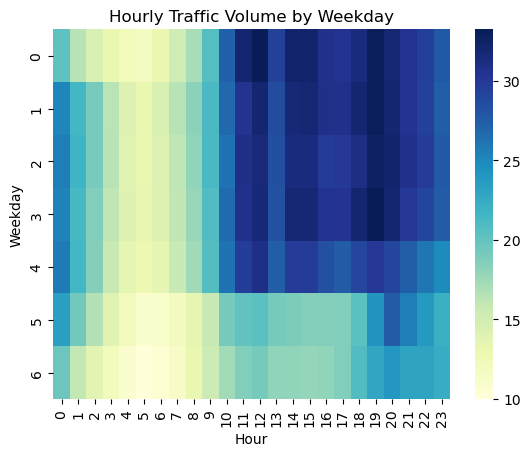

In [14]:
# Heatmap: Weekly pattern
sns.heatmap(weekday_pattern, cmap='YlGnBu')
plt.title("Hourly Traffic Volume by Weekday")
plt.show()



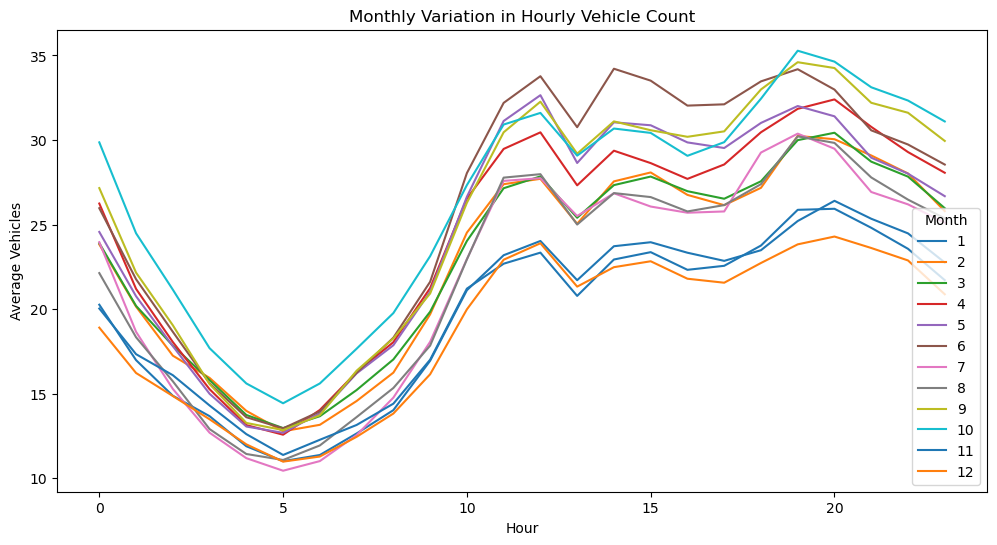

In [19]:
# Lineplot: Monthly
monthly_pattern.T.plot(figsize=(12,6))
plt.title("Monthly Variation in Hourly Vehicle Count")
plt.xlabel("Hour")
plt.ylabel("Average Vehicles")
plt.legend(title='Month')
plt.show()


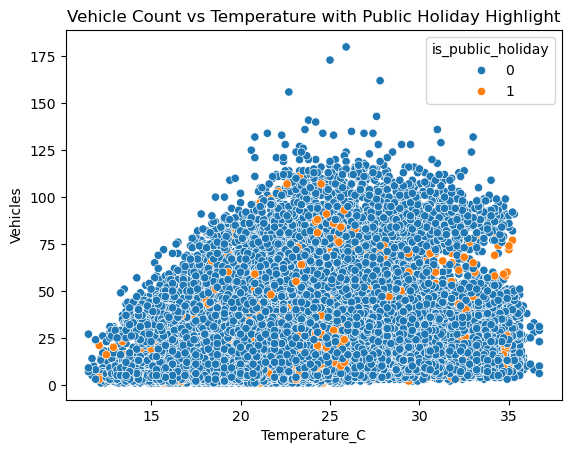

In [16]:
# Scatter: Weather effects
sns.scatterplot(data=df, x='Temperature_C', y='Vehicles', hue='is_public_holiday')
plt.title("Vehicle Count vs Temperature with Public Holiday Highlight")
plt.show()

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['Hour', 'IsWeekend', 'Lag_1hr', 'Lag_24hr', 'Temperature_C', 'Precipitation_mm',
        'WindSpeed_kmh', 'Humidity_%', 'is_public_holiday', 'is_sports_event',
        'is_concert', 'is_public_demonstration']]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                    feature         VIF
0                     const  152.068481
1                      Hour    1.240948
2                 IsWeekend    1.074542
3                   Lag_1hr    5.367007
4                  Lag_24hr    5.343706
5             Temperature_C    2.585141
6          Precipitation_mm    1.061722
7             WindSpeed_kmh    1.033743
8                Humidity_%    2.699589
9         is_public_holiday    1.007343
10          is_sports_event    1.037457
11               is_concert    1.018685
12  is_public_demonstration    1.005794


In [26]:
hourly_congestion

,Junction,Hour,Avg_Vehicles,Smoothed_Vehicles
0,1,0,45.789127,45.789127
1,1,1,39.199341,42.494234
2,1,2,33.947282,39.645250
3,1,3,29.467875,34.204833
4,1,4,25.682043,29.699066
...,...,...,...,...
91,4,19,8.883333,8.827778
92,4,20,9.044444,8.816667
93,4,21,8.438889,8.788889
94,4,22,8.788889,8.757407


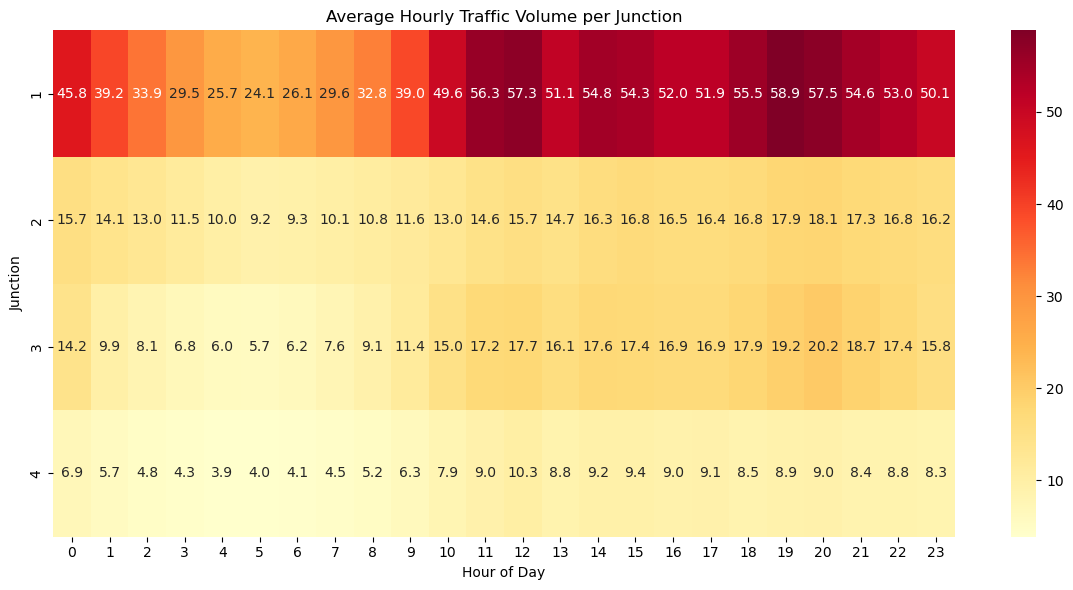

In [18]:
heatmap_data = hourly_congestion.pivot(index='Junction', columns='Hour', values='Avg_Vehicles')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title("Average Hourly Traffic Volume per Junction")
plt.xlabel("Hour of Day")
plt.ylabel("Junction")
plt.tight_layout()
plt.show()

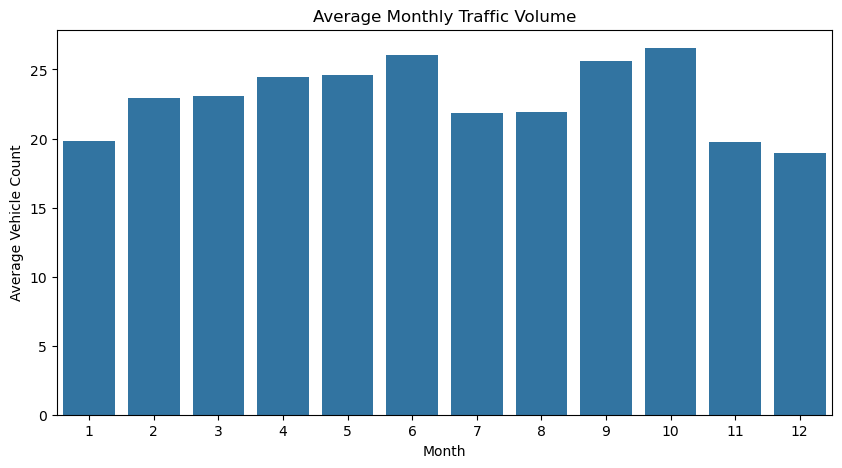

In [21]:
# Create a bar plot to visualize the average vehicle count per month
monthly_data = df.groupby('Month')['Vehicles'].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_data.index, y=monthly_data.values)
plt.title('Average Monthly Traffic Volume')
plt.xlabel('Month')
plt.ylabel('Average Vehicle Count')
plt.show()
